## this notebook is for smoothing transmission spectra produced with Exo-Transmit

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**here is a transit spectrum for TOI-1899 b**

In [2]:
# Can be found in kipping/Exo_Transmit/Spectra
# as of 19 Jan 2024
spectra_path = '/Users/coffey/Downloads/kipping/Exo_Transmit/Spectra'

In [3]:
TOI1899b_spec        = np.loadtxt(f'{spectra_path}/transmission_TOI1899b.dat', skiprows = 2).T
TOI1899b_wavelength  = TOI1899b_spec[0] * 1e6 # microns

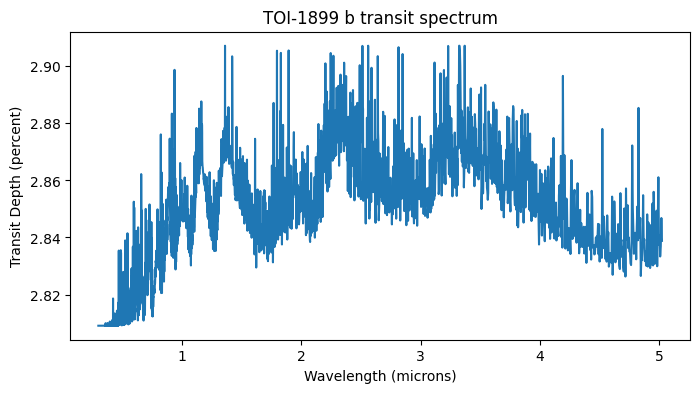

In [4]:
plt.figure(figsize = (8,4))
plt.title('TOI-1899 b transit spectrum')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit Depth (percent)')

plt.plot(TOI1899b_wavelength[:2825], TOI1899b_spec[1][:2825])

plt.show()

**Exo-Transmit produces a spectrum from $0.3 - 30 \mu m$ at a fixed spectral resolution of $R = \lambda / \Delta\lambda = 1000$. JWST's NIRSPEC operates over a wavelength range of $0.6 - 5.3 \mu m$ at spectral resolutions of ~100 (prism), ~1000, and ~2700, depending on the observing mode.**

**first I'm gonna write a normal smoothing algorithm, then make it adaptive**

In [5]:
wavelength = TOI1899b_wavelength[:2825]
spectrum   = TOI1899b_spec[1][:2825]

In [6]:
num_points = len(wavelength)
num_points

2825

In [7]:
# arbitrary bin size
binn = 25

In [8]:
spectrum[:binn].mean()

2.809077

In [9]:
smooth_spec = []

In [10]:
for i in range(len(spectrum)):
    mean = spectrum[i:binn+i].mean()
    smooth_spec.append(mean)

**Plot to compare smoothed spectrum to original.**

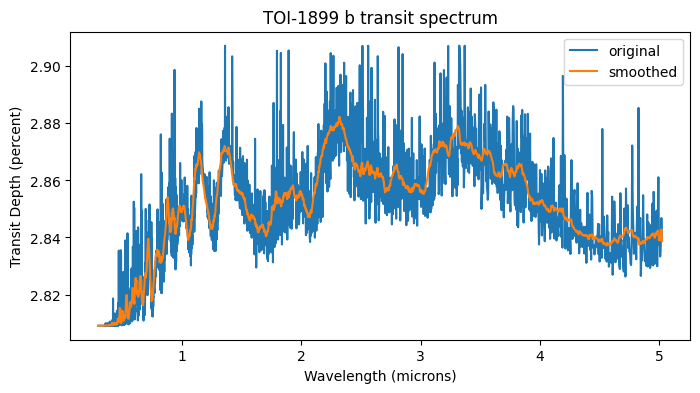

In [11]:
plt.figure(figsize = (8,4))
plt.title('TOI-1899 b transit spectrum')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit Depth (percent)')

plt.plot(wavelength, spectrum, label = 'original')
plt.plot(wavelength, smooth_spec, label = 'smoothed')

plt.legend()
plt.show()

**Now make it adaptive smoothing**

To start, we need to find the center of the first bin. Since we will be using $\Delta\lambda = \lambda / R$, we know that the wavelength corresponding to the center of the first bin should follow this equation $\lambda - \Delta\lambda/2 = min(\lambda)$. Putting these together gives us $\lambda = [2R * min(\lambda)]/[2R - 1]$

In [12]:
def adap_smooth(wave, spec, R):
    """
    Smooths to a fixed spectral resolution according to:
    
    R = lamb / deltalamb
    
    Thus, the bin size changes for each wavelength.
    
    ================== Params ==================
    
    wave   : array or list of wavelengths
    spec   : array or list of transit depths
    R      : spectral resolution (JWST NIRSPEC: ~100 (prism), ~1000, or ~2700)
    
    ============================================
    
    """
    
    # Finding center of first bin
    # using equation lamb = 2R*np.min(lambs) / (2R-1)
    lamb0 = (2*R*wave[0]) / (2*R - 1)
    dellamb = lamb0 / R
    
    # binning wavelengths w/n +- dellamb/2 of lamb0
    bin_indices = np.where(np.logical_and(wave >= lamb0 - dellamb/2, wave < lamb0 + dellamb/2))
    
    # taking mean in bin
    mean0 = spec[bin_indices].mean()
    
    # creating list to store the smooth spectrum
    smooth_spec = [mean0]
    
    # repeating everything above for every bin
    for i in range(1,len(spec)):
        lamb = wave[i]
        dellamb = lamb / R
        bin_indices = np.where(np.logical_and(wave >= lamb - dellamb/2, wave < lamb + dellamb/2))
        mean = spec[bin_indices].mean()

        smooth_spec.append(mean)
    
    return smooth_spec

In [13]:
adap_smooth_spec = adap_smooth(wavelength, spectrum, R = 10)

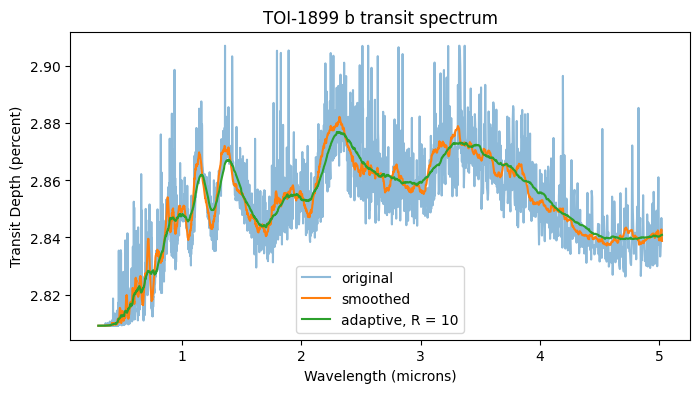

In [14]:
plt.figure(figsize = (8,4))
plt.title('TOI-1899 b transit spectrum')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit Depth (percent)')

plt.plot(wavelength, spectrum, label = 'original', alpha = 0.5)
plt.plot(wavelength, smooth_spec, label = 'smoothed')
plt.plot(wavelength, adap_smooth_spec, label = 'adaptive, R = 10')

plt.legend()
plt.show()

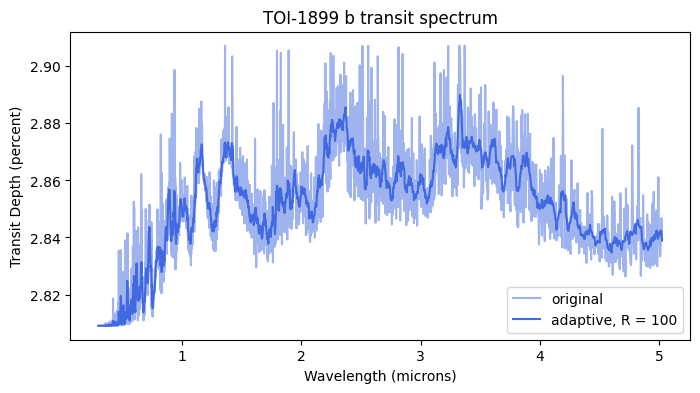

In [15]:
plt.figure(figsize = (8,4))
plt.title('TOI-1899 b transit spectrum')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit Depth (percent)')

plt.plot(wavelength, spectrum, label = 'original', color = 'royalblue', alpha = 0.5)
plt.plot(wavelength, adap_smooth(wavelength, spectrum, R = 100), label = 'adaptive, R = 100', color = 'royalblue')

plt.legend()
plt.savefig('toi1899b_smooth_spec.png')
plt.show()

**JWST has different spectral resolutions depending on the observing mode, we want PRISM data which has R ~ 100**

In [16]:
R100 = adap_smooth(wavelength, spectrum, R = 100)
R1000 = adap_smooth(wavelength, spectrum, R = 1000)
R2700 = adap_smooth(wavelength, spectrum, R = 2700)

**ExoTransmit is at a fixed spectral resolution of R = 1000, so the R1000 and R2700 smoothed spectra will be identical to what we started with.**

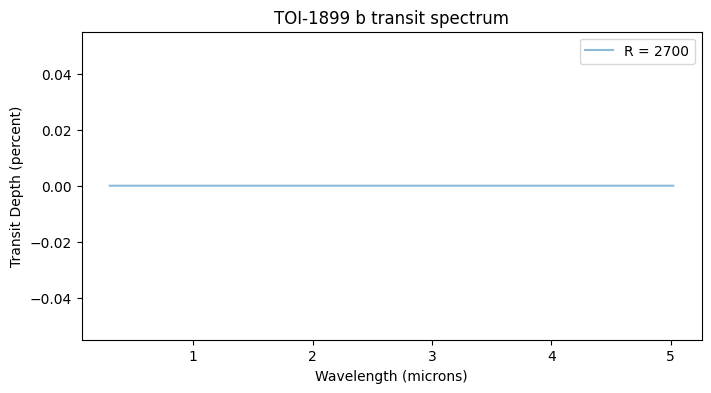

In [17]:
plt.figure(figsize = (8,4))
plt.title('TOI-1899 b transit spectrum')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit Depth (percent)')

plt.plot(wavelength, spectrum - R2700, label = 'R = 2700', alpha = 0.5)

plt.legend()
plt.show()

In [18]:
np.sum(spectrum - R2700)

0.0

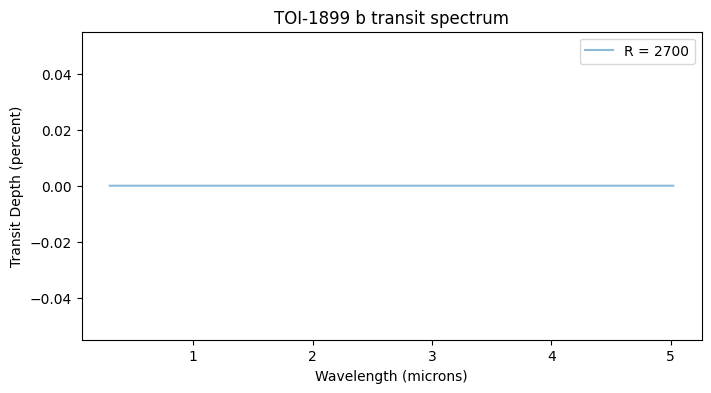

In [19]:
plt.figure(figsize = (8,4))
plt.title('TOI-1899 b transit spectrum')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit Depth (percent)')

plt.plot(wavelength, spectrum - R1000, label = 'R = 2700', alpha = 0.5)

plt.legend()
plt.show()

In [20]:
np.sum(spectrum - R1000)

0.0

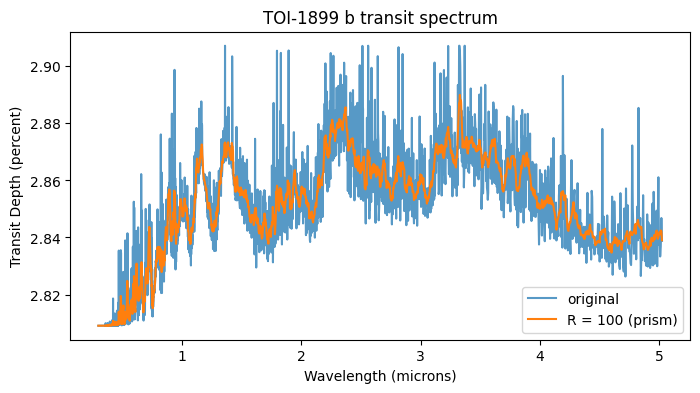

In [21]:
plt.figure(figsize = (8,4))
plt.title('TOI-1899 b transit spectrum')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Transit Depth (percent)')

plt.plot(wavelength, spectrum, label = 'original', alpha = 0.75)
plt.plot(wavelength, R100, label = 'R = 100 (prism)')

plt.legend()
plt.show()